<img src="data/photutils_banner.svg" width=500 alt="Photutils logo" style="margin-left: 0;">

<div class="alert alert-block alert-info">
<h2 style="margin-top: 0">In this notebook, we will cover:</h2>

- The basics of PSF photometry using a simulated 2D Gaussian PSF
</div>

# Preliminaries

In [1]:
# Initial imports
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import QTable
from astropy.visualization import simple_norm
from photutils.datasets import make_noise_image
from photutils.detection import DAOStarFinder
from photutils.psf import (CircularGaussianPRF, PSFPhotometry, IterativePSFPhotometry,
                           make_psf_model_image)

# Change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'

# Run the %matplotlib magic command to enable inline plotting
# in the current notebook.
%matplotlib inline

# Point Spread Function Photometry with Photutils

The Photutils PSF photometry module provides modular tools that allow users to completely customize the photometry procedure, e.g., by using different source detection algorithms, local background estimators, source groupers, and PSF models. Photutils provides implementations for each subtask involved in the photometry process, however, users are still able to include their own custom implementations.

This modularity is accomplished by using an object oriented programming approach that provides a more convenient user experience.

Photutils provides two basic classes to perform PSF photometry, `PSFPhotometry` and `IterativelyPSFPhotometry`. In this notebook, we will cover the basics of the `PSFPhotometry` class.

First, let's create a PSF model for our sources.

In [2]:
psf_model = CircularGaussianPRF(flux=100, fwhm=2.7)

## Create a simulated image

### with 250 stars in a 1000 x 1000 image

In [3]:
psf_shape = (9, 9)
nsources = 250
shape = (1000, 1000)
data, true_params = make_psf_model_image(shape, psf_model, nsources,                    
                                         flux=(500, 1000), min_separation=25,
                                         seed=0, progress_bar=True)

Add model sources:   0%|          | 0/250 [00:00<?, ?it/s]

Now let's add some noise to the image.

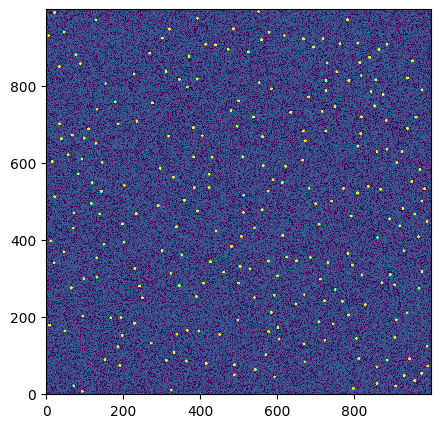

In [4]:
noise = make_noise_image(data.shape, mean=0, stddev=0.1)
data += noise
error = np.abs(noise)
plt.figure(figsize=(5, 5))
norm = simple_norm(data, 'sqrt', vmin=-0.1, vmax=2.0)
plt.imshow(data, norm=norm);

The `true_params` output contains an Astropy table containing the true (x, y, flux) of our artificial sources.

In [5]:
true_params

id,x_0,y_0,flux
int64,float64,float64,float64
1,635.3181470735968,730.9638497737808,942.6021109894275
2,272.5492731987039,132.06407498888592,845.3227257698417
3,46.481841648960355,939.6868642958971,741.0035251804089
4,22.329303902186744,511.53703933096847,839.7540663197608
5,809.5109963298692,643.5835298335652,917.8793757824939
6,907.8025103503891,20.328413587669804,566.6205634692519
7,605.3561464579738,141.5894961495703,837.402186134686
8,726.7426022521904,813.5972286121,776.4437369041168
9,543.1014915678378,63.45474803349204,816.8244244850199


# The `PSFPhotometry` class

First, we create the `PSFPhotometry` class instance with a few parameters.

We must input a PSF model, which must be an Astropy `Fittable2DModel`.  Photutils provides several PSF models, including a [`GriddedPSFModel`](https://photutils.readthedocs.io/en/latest/api/photutils.psf.GriddedPSFModel.html#photutils.psf.GriddedPSFModel) for spatially-varying PSFs.

We must also input the `fit_shape` parameter, which defines the region around the center of the PSF that is used for fitting the model.

The `finder` keyword takes a Photutils finder object.  Here, we use the `DAOStarFinder`.  We also input an `aperture_radius` (in pixel) to estimate the initial source fluxes.

In [6]:
fit_shape = (5, 5)
fit_shape = 5
finder = DAOStarFinder(6.0, 2.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder, aperture_radius=5, progress_bar=True)

To perform the PSF fitting, we call the `psfphot` object on the data and optional error array.  The result is an Astropy Table. Here, we print only the first 10 rows.

In [7]:
phot = psfphot(data, error=error)
phot[:10]

Fit source/group:   0%|          | 0/250 [00:00<?, ?it/s]

id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,qfit,cfit,flags
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64
1,1,1,0.0,93.8708355284969,6.331198788956308,842.629010530629,93.86867383019707,6.325117467952549,843.0297839000991,0.00030464427495121394,0.00029238523786128664,0.244087096460298,25,0.027303220685577063,0.0012221409516989237,0
2,2,1,0.0,324.44131307331094,9.715375007226172,734.0011523867066,324.4191531584416,9.716334646910108,737.0894988085347,0.00028950556524799594,0.00043319174938720483,0.23861575856766443,25,0.02970701415117448,0.0012230755066194433,0
3,3,1,0.0,798.2590325204288,13.612503140872096,748.283188602994,798.2583249941482,13.624797615441032,747.405676586058,0.00027764960174336736,0.000399130590179341,0.13271007645254718,25,0.028936054150453746,0.0006560551381819336,0
4,4,1,0.0,907.8049855579208,20.336058959673103,565.5474941611121,907.8032274922509,20.328296446056367,566.6358791331711,0.0004242550957056015,0.0003729280600540362,0.1634613038527061,25,0.037757684458387356,0.001400380475966358,0
5,5,1,0.0,71.29360041233413,20.698970156285064,595.1503121743876,71.2895983294945,20.70199633678842,595.39519064117,0.00028207736713230485,0.00025357362764253446,0.05902923522133438,25,0.037923442878184374,0.0008294270855007524,0
6,6,1,0.0,859.2770199154113,26.99888946159744,785.0091406281128,859.2766839119959,26.997615309241265,786.6655591906432,0.00047545256568230944,0.0004077243759580876,0.18524806035260882,25,0.02970791876715252,-0.0008818642860400002,0
7,7,1,0.0,956.8766754122445,34.51411052913782,769.1934900728052,956.8741947934061,34.47752618484349,769.18338092266,0.00022540914899191568,0.00010387564740177838,0.13369938992745872,25,0.028483559928747872,-0.0004029769751902221,0
8,8,1,0.0,593.1657246458146,44.16296977642542,699.5839345350033,593.1684870008354,44.16605707444049,701.7598204231399,6.516653735038055e-05,0.00022030793918428263,0.04565699754768448,25,0.03262813438950372,0.001619975189941376,0
9,9,1,0.0,929.8547291702183,47.51184520096657,628.9946511436692,929.8518018109697,47.47479539388832,630.1655329870524,0.00014852142077838572,0.00020163745729962417,0.11466589727031531,25,0.035635845280232586,-0.0017911194954678647,0


We can use the `make_model_image` method to create a PSF model image of the results.

Add model sources:   0%|          | 0/250 [00:00<?, ?it/s]

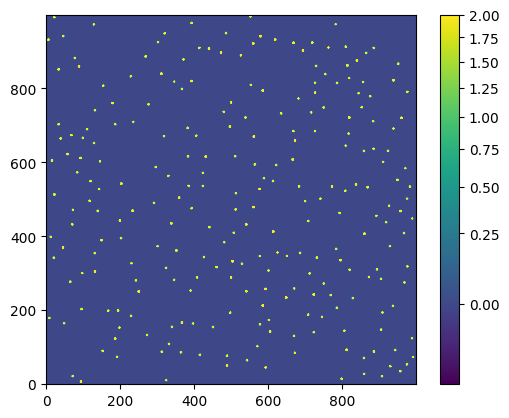

In [8]:
model_img = psfphot.make_model_image(data.shape)
plt.imshow(model_img, norm=norm);
plt.colorbar()

We can use the `make_residual_image` method to create a residual image.

Add model sources:   0%|          | 0/250 [00:00<?, ?it/s]

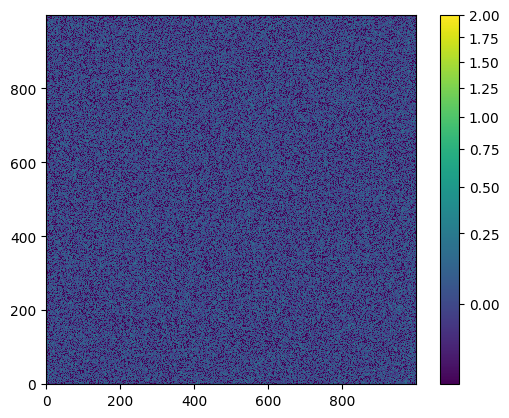

In [9]:
resid = psfphot.make_residual_image(data)
plt.imshow(resid, norm=norm);
plt.colorbar()

Our residual image is just noise without any sources, which indicates excellent PSF model fits.

## Inputing the initial parameters

Instead of using a star finder, we can pass in a Table of the initial (x, y) positions. To get good results, the initial positions
should be very close to the actual positions. You can use a star finder or centroid algorithm to get good initial positions.
This initial parameters table can also include the initial fluxes.

Let's use the `init_param` table, but shift the (x, y, flux) values by a small amount from their true values (see the `true_params` table defined above).

In [10]:
rng = np.random.default_rng(seed=123)
init_params = true_params.copy()
n_sources = len(true_params)
init_params['x_0'] = init_params['x_0'] + rng.uniform(-0.5, 0.5, n_sources)
init_params['y_0'] = init_params['y_0'] + rng.uniform(-0.5, 0.5, n_sources)
init_params['flux'] = init_params['flux'] + rng.uniform(-10, 10, n_sources)
init_params[:10]

id,x_0,y_0,flux
int64,float64,float64,float64
1,635.500498936845,730.9697209930014,950.2042646683324
2,272.1030942175061,132.31981388099592,836.4636743589657
3,46.20220152173297,939.6758879987103,747.0288114652038
4,22.013675712885416,511.86276692130446,847.1457561899687
5,809.1869022309542,643.6239979739985,912.777624312376
6,908.1146048570448,20.18559678939897,576.1596269955131
7,605.7794914560008,141.89547363045284,834.8388080207271
8,726.5191766499876,813.2836071587824,769.6108547184779
9,543.4212461294308,63.84403706527827,815.214227617267


Since we are inputing the initial (x, y) values, we no longer need to input the `finder`.  Likewise, since we are inputing the initial flux values, we no longer need to input the `aperture_radius`.

In [11]:
psfphot2 = PSFPhotometry(psf_model, fit_shape, fitter_maxiters=100, progress_bar=True)
phot2 = psfphot2(data, error=error, init_params=init_params)
phot2[:10]

Fit source/group:   0%|          | 0/250 [00:00<?, ?it/s]

id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,qfit,cfit,flags
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64
1,1,1,0.0,635.500498936845,730.9697209930014,950.2042646683324,635.3186770908009,730.9635330189624,942.7204402230174,0.00031666979532169576,0.0003438034188624668,0.18764974351367075,25,0.023539798713162582,0.0004646779634793447,0
2,2,1,0.0,272.1030942175061,132.31981388099592,836.4636743589657,272.54880671708537,132.06447697068185,845.3414783124496,0.0002791201510643707,0.0002901961467941598,0.10662803553993846,25,0.024258136750086964,0.0008676152164713087,0
3,3,1,0.0,46.20220152173297,939.6758879987103,747.0288114652038,46.48180635621945,939.6869446510159,741.1480688188394,0.00025288861774642904,0.00022087498068631747,0.09899986927407003,25,0.029296578147521717,-0.0016571829000290293,0
4,4,1,0.0,22.013675712885416,511.86276692130446,847.1457561899687,22.32959230566787,511.53733325978584,839.6659101279552,0.000227155357496919,0.00024207411450299544,0.08115117874237415,25,0.026659396818488546,-0.0005879344615212652,0
5,5,1,0.0,809.1869022309542,643.6239979739985,912.777624312376,809.5110090173936,643.5831763663605,917.9535614576421,6.967720013453051e-05,0.00016529897904035855,0.08022420310236039,25,0.022240646258073173,0.0011233067088038584,0
6,6,1,0.0,908.1146048570448,20.18559678939897,576.1596269955131,907.8032274922518,20.32829644605613,566.6358791284931,0.0004242550957091224,0.00037292806005700106,0.16346130385275603,25,0.03775768439541842,0.0014003804949121502,0
7,7,1,0.0,605.7794914560008,141.89547363045284,834.8388080207271,605.3562026266258,141.58951375732877,837.455577986905,0.00019145755583677338,0.00015211185557561748,0.1252274819468843,25,0.02844443855711672,0.0007013474750130817,0
8,8,1,0.0,726.5191766499876,813.2836071587824,769.6108547184779,726.7426473353646,813.5973101114284,776.4267963843513,6.627313311890881e-05,5.282573385603325e-05,0.04748516237981308,25,0.02883903284379445,-0.0012529324788868547,0
9,9,1,0.0,543.4212461294308,63.84403706527827,815.214227617267,543.1017971502239,63.45532976184233,816.877726363451,0.00032271743583611734,0.0002954492296844255,0.1483455127927496,25,0.02669829482261295,-0.0014697356088839357,0


Add model sources:   0%|          | 0/250 [00:00<?, ?it/s]

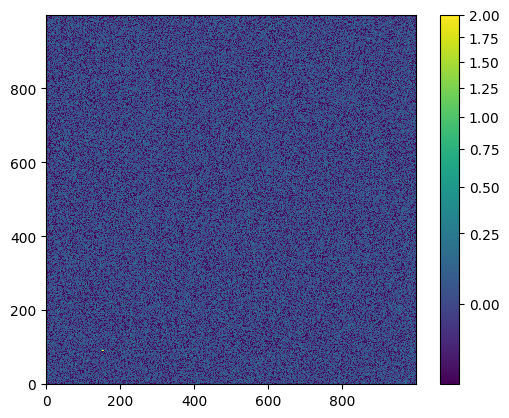

In [12]:
resid2 = psfphot2.make_residual_image(data)
plt.imshow(resid2, norm=norm);
plt.colorbar()

Since the sources are ordered, we can directly compare the fit values with the true values.

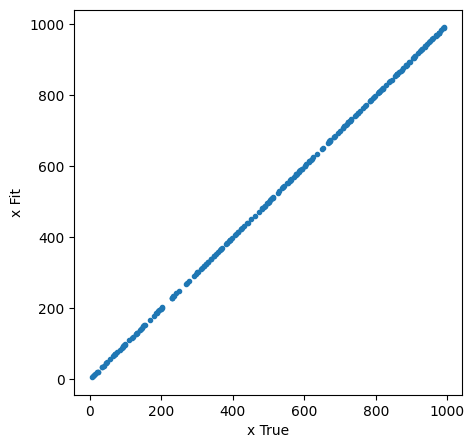

In [13]:
plt.figure(figsize=(5, 5))
plt.plot(true_params['x_0'], phot2['x_fit'], '.')
plt.xlabel('x True')
plt.ylabel('x Fit');

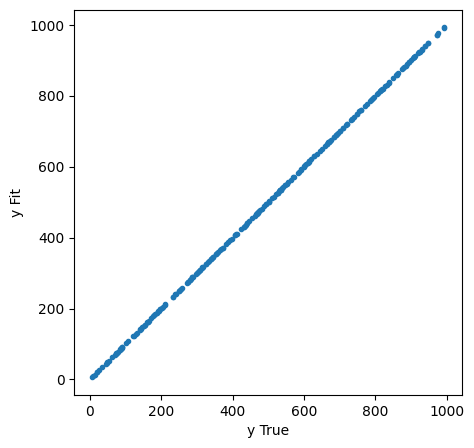

In [14]:
plt.figure(figsize=(5, 5))
plt.plot(true_params['y_0'], phot2['y_fit'], '.')
plt.xlabel('y True')
plt.ylabel('y Fit');

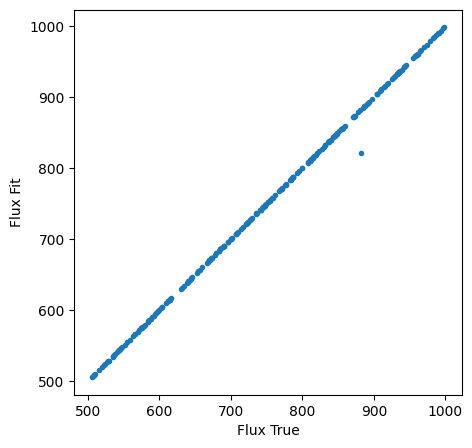

In [15]:
plt.figure(figsize=(5, 5))
plt.plot(true_params['flux'], phot2['flux_fit'], '.')
plt.xlabel('Flux True')
plt.ylabel('Flux Fit');

In [16]:
pdiff = (true_params['flux'] - phot2['flux_fit']) / true_params['flux'] * 100.0
np.max(np.abs(pdiff))

np.float64(6.8868054523999005)

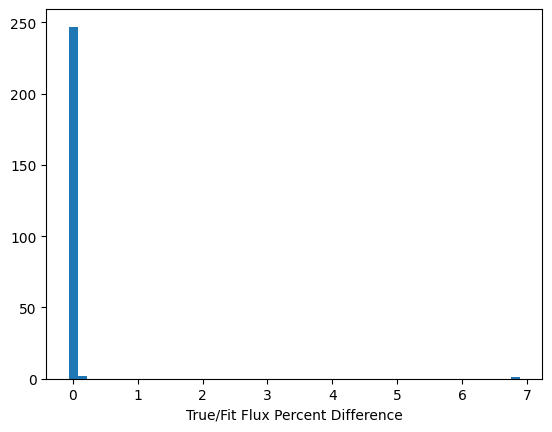

In [17]:
plt.hist(pdiff, bins=50)
plt.xlabel('True/Fit Flux Percent Difference');

Please consult the [PSF Photometry documentation](https://photutils.readthedocs.io/en/stable/user_guide/psf.html) for additional features including:

- Fitting a single (or few) sources in an image
- Forced Photometry
- Source Grouping
- Local Background Subtraction
- Iterative PSF Photometry